# Introduction

In this notebook, you will get a **brief introduction to some of the water quality data** that will be available during the hackathon. The dataset includes different types of parameters, such as:

* **Physicochemical parameters**: These describe the physical and chemical properties of water, such as temperature, pH, dissolved oxygen, conductivity, turbidity, and concentrations of nutrients or ions (e.g., nitrates, phosphates, chloride). They are key indicators of overall water quality.

* **Biological (hydrobiological) parameters**: These capture the living components of aquatic ecosystems, such as the presence and abundance of algae, plankton, macroinvertebrates, or bacteria. They help assess the ecological health of the water body and its ability to support life.

These parameters are typically measured using **grab samples**, meaning that a water sample is collected at a single location and time. These samples are then **analyzed in the laboratory** to determine their physicochemical and biological characteristics.

Please note that this is **only a subset** of the full dataset provided for the hackathon. The goal here is simply to help you start exploring the data and become familiar with its structure through **visualizations**, which are provided in separate scripts that are called directly from this notebook.

Feel free to:

* Use the code as is,
* Modify it for your own needs,
* Take inspiration from the examples, or
* Simply use the tools to explore the data and get a first impression of what can be done.

By the end of this notebook, you should have a good starting point for working with the water quality data and preparing your own analyses for the hackathon.

## Preliminary steps and loading of the data


In [1]:
from google.colab import drive, output

drive.mount('/content/drive')      # grants notebook access to Drive

Mounted at /content/drive


In [2]:
from pathlib import Path

main_folder_path = Path('/content/drive/MyDrive/Waternet/Hackathon')

For this tutorial, we will be looking at the Physicochemical parameters. Feel free to redo everything with Hydrobiological data.

In [75]:
import pandas as pd

# FYCHEM
file_path = main_folder_path / 'data/FYCHEM_sampled50locations.csv'
df = pd.read_csv(file_path, sep=';', encoding='latin1', low_memory=False)  # or encoding='cp1252'

# # HYDROBIOLOGIE
# file_path = main_folder_path / 'data/HB_sampled50locations.csv'
# df = pd.read_csv(file_path, sep=';', encoding='latin1', low_memory=False)  # or encoding='cp1252'

display(df.head())

,monsterident,locatiecode,locatie namespace,locatie omschrijving,locatie x,locatie y,locatie z,locatie referentievlakzcoord,locatie KRW watertype,locatie EAG,...,fewsparametereenheidequivalent,fewsparametereenheidreferentie,fewsparameterparameterfractie,limietsymbool,meetwaarde,eenheid,waardebewerkingsmethode,kwaliteitsoordeelcode,afronding,opmerkingmeting
0,WN_FC1977010036,GSW002,NL11,Voor krooshek gemaal Gaaspermolen langs Lange ...,128859,480426,NaN,NaN,M8,2310-EAG-5,...,N,NaN,NaN,NaN,6.40,mg/l,MET,0,Ja,NaN
1,WN_FC1977010036,GSW002,NL11,Voor krooshek gemaal Gaaspermolen langs Lange ...,128859,480426,NaN,NaN,M8,2310-EAG-5,...,N,NaN,nf,NaN,0.13,mg/l,MET,0,Ja,NaN
2,WN_FC1977010036,GSW002,NL11,Voor krooshek gemaal Gaaspermolen langs Lange ...,128859,480426,NaN,NaN,M8,2310-EAG-5,...,NaN,NaN,NaN,NaN,0.25,m,MET,0,Ja,NaN
3,WN_FC1977010036,GSW002,NL11,Voor krooshek gemaal Gaaspermolen langs Lange ...,128859,480426,NaN,NaN,M8,2310-EAG-5,...,N,NaN,nf,NaN,5.90,mg/l,MET,0,Ja,NaN
4,WN_FC1977010036,GSW002,NL11,Voor krooshek gemaal Gaaspermolen langs Lange ...,128859,480426,NaN,NaN,M8,2310-EAG-5,...,NaN,NaN,NaN,NaN,175.00,mg/l,MET,0,Ja,NaN


In [76]:
# Compute average number of measurements per sample
unique_ids = df['monsterident'].unique()
print(f'Avg. measurements per sample: {len(df)/len(unique_ids):0.1f}')

Avg. measurements per sample: 24.0


## Basic plots

The following barcharts will present:
*   the number of samples available for different variables, across all locations;
*   the number of samples per location;
*   the monitoring duration, i.e., the time span between the first and the last measurement taken at a location.

Be aware that we are working with a subset of all the data that we will use.



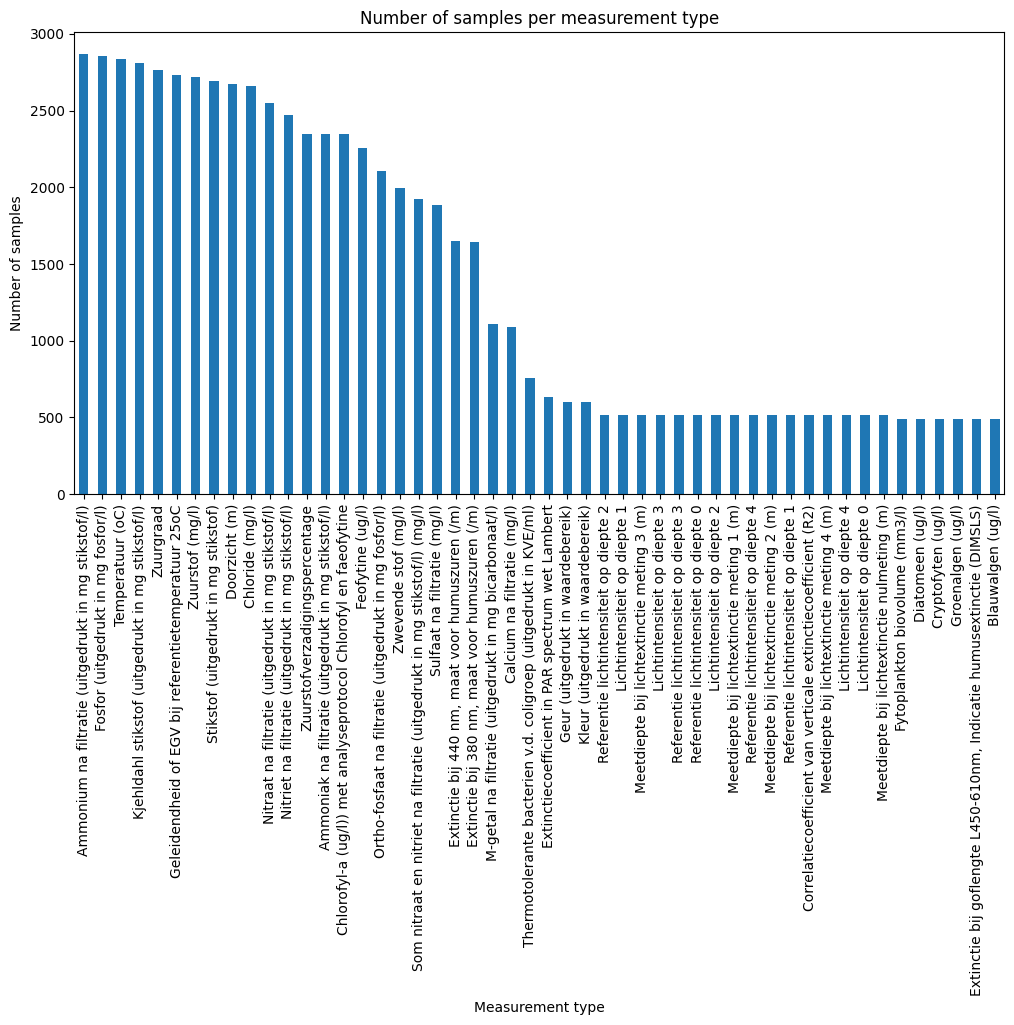

In [77]:
import matplotlib.pyplot as plt

# Count samples per measurement type
counts = df['fewsparameternaam'].value_counts().head(50)  # limit to only most numerous

# Plot histogram (bar chart)
plt.figure(figsize=(12,6))
counts.plot(kind='bar')

plt.title("Number of samples per measurement type")
plt.xlabel("Measurement type")
plt.ylabel("Number of samples")
plt.xticks(rotation=90)
plt.show()

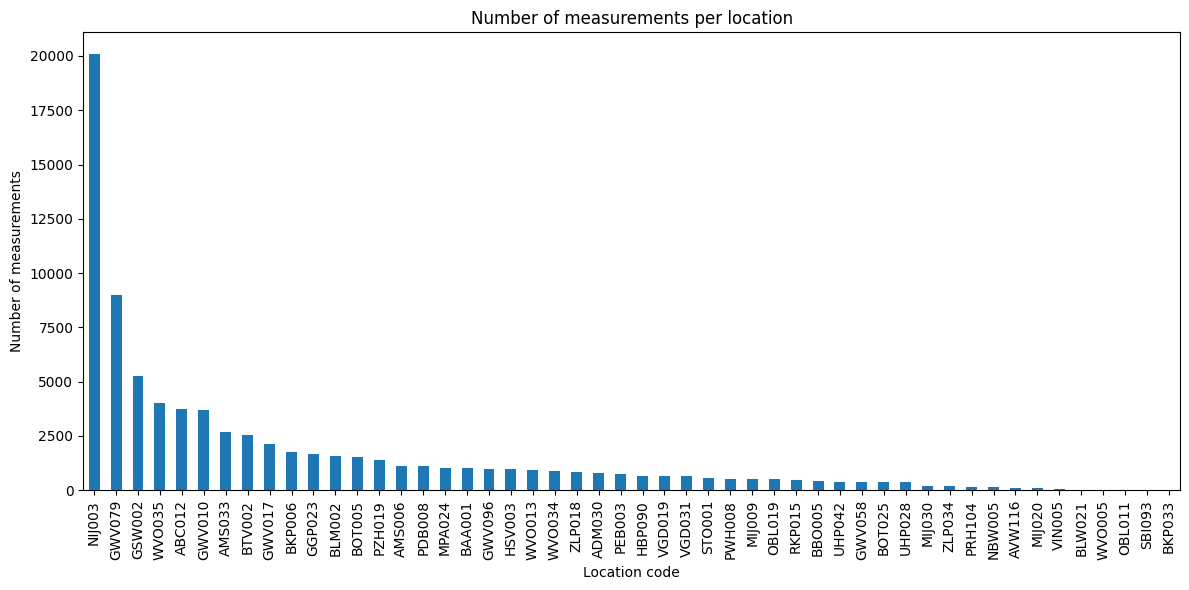

In [78]:
# Count samples per location
counts = df['locatiecode'].value_counts().head(50)

# Plot
plt.figure(figsize=(12,6))
counts.plot(kind='bar')

plt.title("Number of measurements per location")
plt.xlabel("Location code")
plt.ylabel("Number of measurements")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

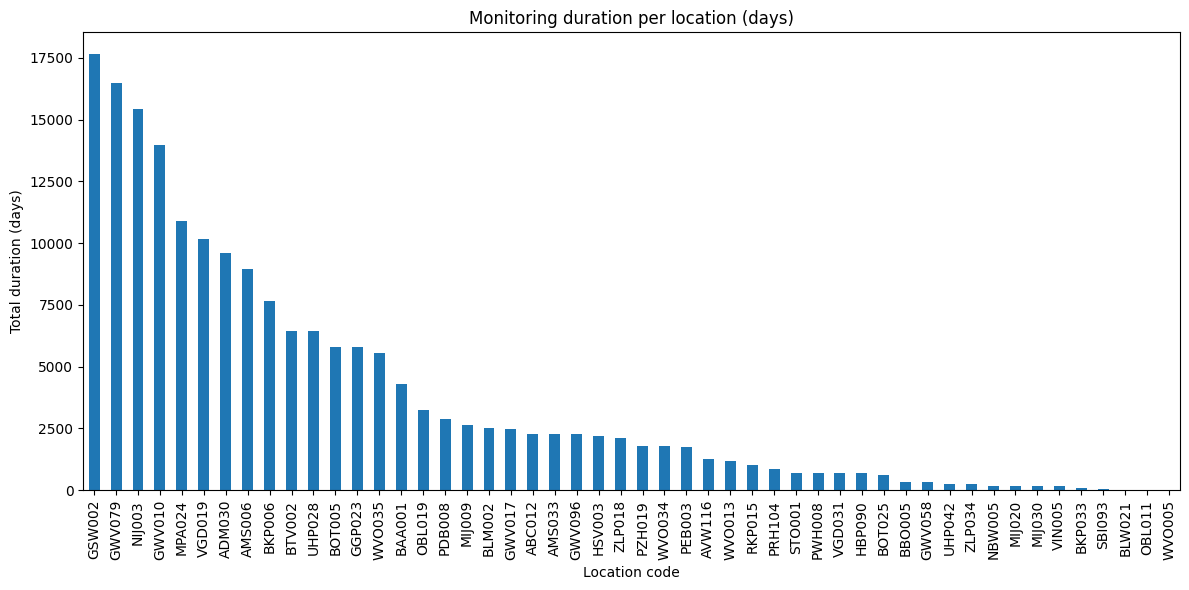

In [79]:
# Ensure 'datum' is datetime
df['datum'] = pd.to_datetime(df['datum'], errors='coerce')

# Group by location
agg = df.groupby('locatiecode').agg(
    start_time = ('datum', 'min'),
    end_time   = ('datum', 'max'),
    duration_days = ('datum', lambda x: (x.max() - x.min()).days)
).reset_index()

# Also compute the average duration between consecutive samples at each location
df_sorted = df.sort_values(['locatiecode', 'datum'])
df_sorted['delta_days'] = df_sorted.groupby('locatiecode')['datum'].diff().dt.days

avg_durations = df_sorted.groupby('locatiecode')['delta_days'].mean().reset_index(name='avg_interval_days')

# Merge results
result = agg.merge(avg_durations, on='locatiecode', how='left')

result.head()

plt.figure(figsize=(12,6))
result.sort_values('duration_days', ascending=False).head(50).set_index('locatiecode')['duration_days'].plot(kind='bar')

plt.title("Monitoring duration per location (days)")
plt.ylabel("Total duration (days)")
plt.xlabel("Location code")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



## Time series visualization: IPyWidgets

In this section, we will explore **how water quality variables change over time** using interactive time series plots.

To do this, we will use **IPyWidgets**, a Python library that allows us to add interactive elements (such as dropdown menus and sliders) directly into Jupyter or Colab notebooks. With these widgets, we can:

* Select **two stations** and compare how the same variable evolves over time at both locations.
* Select **one station** and visualize **multiple variables** together.
* Select **two different stations** and compare **different variables**.

The goal is to **play around with the data** and get an intuitive sense of how it looks in time. This kind of exploration is useful regardless of your final objective:

* understanding relationships between variables,
* doing preliminary checks before designing a database solution, or
* preparing the ground for more advanced tasks such as building predictive models.

The `max_gap_days` parameter lets you control how many days between two samples are considered a continuous segment. This avoids drawing long connecting lines across large gaps (e.g., between different years) and makes the visualization cleaner.

### About the Code

The actual implementation of the interactive visualizations is available in a **separate script**.

* If you just want to explore the data, you can use it here as a **black box**.
* If you are curious, you are encouraged to **open the scripts**, see how the code works, and even **modify, adapt, or improve** it to suit your own ideas.

This way, you can decide whether to focus only on the exploration, or to dive deeper into the code itself.

In [80]:
import sys

# Add the "scripts" folder to sys.path
scripts_path = main_folder_path / "scripts"
sys.path.append(str(scripts_path))

from station_timeseries_viewers import (
    create_viewer_one_param_two_stations,
    create_viewer_two_params_two_stations,
)


In [81]:
# Example: Visualizing temperature at two stations (NIJ003 and GWV079).
viewer1 = create_viewer_one_param_two_stations(df, max_gap_days=180)
display(viewer1)

In [82]:
# Example: Visualizing pH and temperature at NIJ003
viewer2 = create_viewer_two_params_two_stations(df, max_gap_days=365)
display(viewer2)

In [83]:
# Example: visualize dissolved oxygen at NIJ003 and Fosfor (a "nutrient") in GWV079
viewer3 = create_viewer_two_params_two_stations(df, max_gap_days=365)
display(viewer3)

## Time Series Visualization: Plotly

In this cell, we remake the time-series viewers using **Plotly**. Plotly offers richer interaction than static plots: you can **zoom**, **pan**, use the **range slider**, and inspect points via **hover tooltips**. This makes it easier to spot trends, gaps, and differences across stations or variables.

The Plotly functions currently take the **descriptive parameter name** (e.g., `fewsparameternaam`) as input. This is convenient when selecting via IPyWidgets, but it can be tricky to type exactly when calling the functions directly in code.

Feel free to treat these Plotly utilities as a **black box** for quick exploration, or open the underlying script to adapt the selection logic (e.g.,taking as input `fewsparametercode` could be a better choice).


In [84]:
from station_timeseries_viewers_plotly import (
    make_plotly_timeseries,
    make_plotly_timeseries_two_params,
)

In [85]:
# Example: Visualizing temperature at two stations (NIJ003 and GWV079).
fig = make_plotly_timeseries(df, 'NIJ003', 'GWV079', 'Temperatuur (oC)', max_gap_days=180)
fig.show()

In [86]:
# Example: Visualizing pH and temperature at NIJ003
fig2 = make_plotly_timeseries_two_params(df, 'NIJ003','Zuurgraad', 'NIJ003','Temperatuur (oC)', max_gap_days=180)

fig2.show()


In [87]:
# Example: visualize dissolved oxygen at NIJ003 and Fosfor (a "nutrient") in GWV079
fig3 = make_plotly_timeseries_two_params(df, 'NIJ003','Zuurstof (mg/l)', 'GWV079','Fosfor (uitgedrukt in mg fosfor/l)', max_gap_days=180)
fig3.show()
